# 02 - Exploratory Data Analysis & Transaction Transformation

This notebook loads `data/processed/cleaned_phishing.csv`, performs EDA (class distribution, token frequencies, basket sizes), and converts cleaned text into a binary transaction matrix for Apriori. The transaction matrix is saved to `data/processed/transactions.pkl`.

### Load Processed Data and Imports

In [6]:
%pip install seaborn
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

IN = Path("../data/processed/cleaned_phishing.csv")
TRAN_PKL = Path("../data/processed/transactions.pkl")

df = pd.read_csv(IN)
print("Loaded cleaned data:", df.shape)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded cleaned data: (82486, 4)


### EDA: class balance and basket size

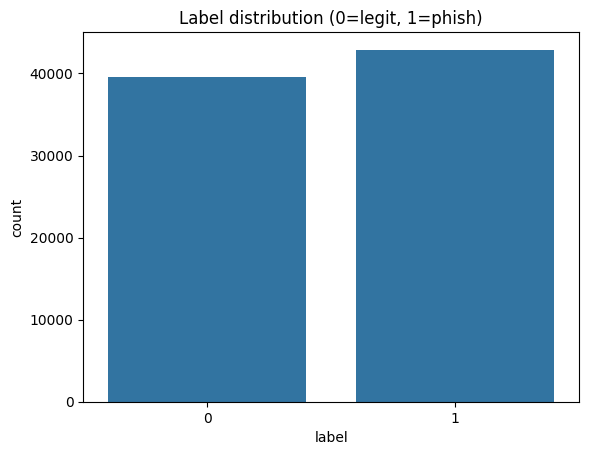

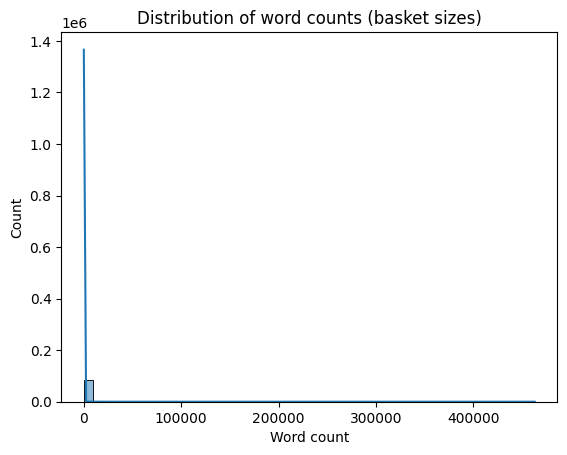

Basket size stats: count     82486.000000
mean        148.130592
std        1661.859711
min           0.000000
25%          33.000000
50%          68.000000
75%         164.000000
max      463175.000000
Name: word_count, dtype: float64


In [7]:
# Class distribution (if label exists)
if 'label' in df.columns:
    sns.countplot(x='label', data=df)
    plt.title('Label distribution (0=legit, 1=phish)')
    plt.show()

# Basket sizes (word counts)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of word counts (basket sizes)')
plt.xlabel('Word count')
plt.show()

print("Basket size stats:", df['word_count'].describe())

### Top Tokens (Phising Subset Option)

In [8]:
# Option: analyze phishing-only tokens to focus ARM on phishing patterns
phish_only = True  # set False to use entire corpus
df_for_tokens = df[df['label']==1] if (phish_only and 'label' in df.columns) else df

all_tokens = ' '.join(df_for_tokens['clean_text'].astype(str)).split()
cnt = Counter(all_tokens)
top20 = cnt.most_common(20)
print("Top 20 tokens ({}):".format('phishing' if phish_only else 'all'))
for t,c in top20:
    print(f"{t}: {c}")

Top 20 tokens (phishing):
email: 28177
aug: 28046
top: 23205
compani: 21688
go: 18829
account: 18698
pleas: 18610
money: 17864
us: 17467
receiv: 16786
one: 16196
news: 15937
time: 15797
inform: 15327
get: 14904
cnncom: 14533
name: 14156
alert: 13547
bank: 12989
secur: 12764


### Transaction Transformation (CountVectorizer)

In [13]:
%pip install scikit-learn

from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Vectorizer parameters — tune for memory / quality
vectorizer = CountVectorizer(
    binary=True,
    min_df=0.002,      # token must appear in >=0.2% of docs; adjust lower if too few itemsets
    max_features=1000  # cap features for runtime; increase if memory allows
)

# Fit on the *clean_text* of the data we want to mine (phish-only or all)
corpus = df_for_tokens['clean_text'].astype(str).values
X = vectorizer.fit_transform(corpus)
transaction_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("Transaction matrix shape:", transaction_df.shape)

# Save transactions (pickle)
TRAN_PKL.parent.mkdir(parents=True, exist_ok=True)
with open(TRAN_PKL, "wb") as f:
    pickle.dump({'transaction_df': transaction_df, 'vectorizer_vocab': vectorizer.get_feature_names_out()}, f)
print("Saved transactions to", TRAN_PKL)

     ---------------------------------------- 8.1/8.1 MB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 38.7/38.7 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Transaction matrix shape: (42891, 1000)
Saved transactions to ..\data\processed\transactions.pkl


Notes:
- `min_df` controls token frequency threshold; lower it to include rarer tokens at the cost of more itemsets and runtime.
- `max_features` limits vocabulary to keep Apriori tractable. If you have sufficient memory and want more detail, increase this value.
- We saved a pickle with the transaction DataFrame and vocabulary for reproducibility.